# Modeling Bankruptcy
This notebook starts where the data exploration notebook left off. We will in this notebook build series of models in order to get to our final model.Once again the data is highly imbalanced so we will experiment with oversampling and use weights within the loss function of catboost to model this.

In [1]:
# installing packages
import sys
import pickle
sys.path.append("../../bankruptcy_prediction")
import pandas as pd
import numpy as np
import sys
# for visualisation
import plotly.io as pio
pio.templates.default = "ggplot2"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# for modelling 
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

import optuna
import imblearn as imb
from collections import Counter

from sklearn.metrics import (PrecisionRecallDisplay, precision_score,
recall_score,confusion_matrix,f1_score)
from sklearn.model_selection import train_test_split
import shap
from utils import (get_shap_feat_importance,check_missing, 
plot_dist_bar, get_dist, read_xlsx, model_performance)


Loading the output data from the exploration notebook and splitting it into `train` and `test` and a `holdout` set

In [2]:
training_data = pd.read_csv("../data/training_data.csv")
testing_data = pd.read_csv("../data/testing_data.csv")
highcorr90 = pd.read_csv("../data/highcorr90.csv")
target="bankruptcy"

data = pd.concat([training_data,testing_data],axis=0).reset_index(drop=True)
print("Original Data Shape",data.shape)

data["company_type"] = data["company_type"].astype("category")

holdout=data.iloc[:50,:]
data = data.iloc[50:,:] 
print("Shape after dropping",data.shape)
X,y = data.drop(target,axis=1),data[target]

#Holdout
print("Shape of holdout",holdout.shape)
print(Counter(holdout[target]))

Original Data Shape (6811, 96)
Shape after dropping (6761, 96)
Shape of holdout (50, 96)
Counter({0: 47, 1: 3})


**Oversampling** is implemented in the code but I found that oversampling was providing very high precision/f1_score which could lead to overfitting for class1. Hence, I decided to use correct weights within the loss function of the model. 

In [3]:
sampling_strategy=False
if sampling_strategy:
    # define oversampling strategy
    # oversample = RandomOverSampler(sampling_strategy='minority')
    oversample = imb.over_sampling.RandomOverSampler(sampling_strategy=0.06)
    # fit and apply the transform
    X_over, y_over = oversample.fit_resample(X, y)
    print(Counter(y_over))
else :
    X_over = X.copy(deep=True)
    y_over = y.copy(deep=True)
    print(Counter(y_over))

Counter({0: 6545, 1: 216})


In [4]:
# splitting the data
X_train,X_test,y_train,y_test = \
    train_test_split(X_over,y_over,test_size=0.3, stratify=y,random_state=42)

In [5]:
# X_train,y_train = training_data.drop("bankruptcy",axis = 1),training_data['bankruptcy']
# X_test,y_test = testing_data.drop("bankruptcy",axis = 1),testing_data['bankruptcy']
print(Counter(y_train))
print(Counter(y_test))

Counter({0: 4581, 1: 151})
Counter({0: 1964, 1: 65})


## Benchmark Model
This is a benchmark model using logistic regression, I have removed highly correlated features we found during the data exploration step. Multicollinearity is an issue classic regression method as the matrix becomes unstable and non-invertible which means either there is no solution or many solutions. This multicollinearity issue doesnt impact tree based models and so since catboost is a GBM model based on trees it is robust to this effect.

**Correct Metric:** For imbalance datasets some metrics are not suitable as they can lead you to believe that your model is performing too well, for e.g. **accuracy or auc/ROC CURVE**. Therefore, we will focus on precision and f1 score. 

Precision helps us to know how precise we are in predicting that some company is going to go bankrupt from the bankrupt predictions. Recall measures how many correct predictions we are able to predict from all bankrupt cases. F1 Score is a harmonic mean between precision and recall so helps us to balance both and we focus on these metrics.

Precision Recall Curve is another visual that helps us to understand how well the model is performing across variour prediction threshold very much like ROC CURVE.

The benchmark model suggest a performance of 0.06 precision and 0.10 f1score which is very low. At this point we have throws almost all features at the model.

Train classification report: 
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      4581
           1       0.06      0.43      0.10       151

    accuracy                           0.76      4732
   macro avg       0.52      0.60      0.48      4732
weighted avg       0.95      0.76      0.84      4732

Test classification report: 
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      1964
           1       0.06      0.42      0.10        65

    accuracy                           0.77      2029
   macro avg       0.52      0.60      0.48      2029
weighted avg       0.95      0.77      0.84      2029



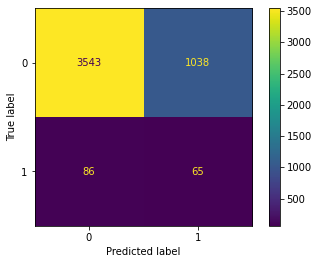

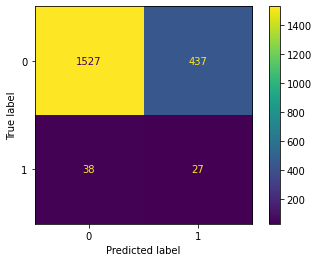

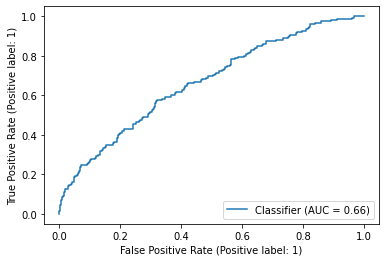

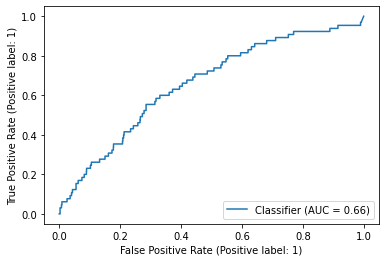

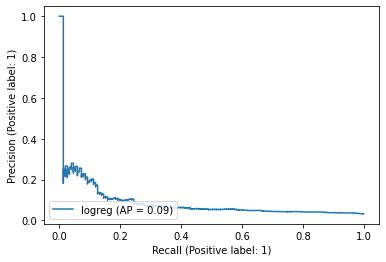

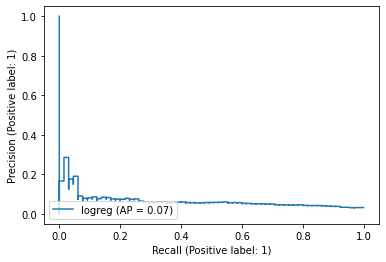

In [6]:
ohe = OneHotEncoder()

drop_high_corr = list(highcorr90["feat1"])
cat_cols = ["company_type"]
drop_cols_lr = drop_high_corr+cat_cols 
X_train_ohe = ohe.fit_transform(X_train[cat_cols]).toarray()
X_test_ohe = ohe.transform(X_test[cat_cols]).toarray()

X_train_lr = X_train.drop(drop_cols_lr,axis=1).copy(deep=True)
X_test_lr = X_test.drop(drop_cols_lr,axis=1).copy(deep=True)

X_train_lr[ohe.categories_[0]] = X_train_ohe
X_test_lr[ohe.categories_[0]] = X_test_ohe


benchmark_mod = LogisticRegression(class_weight="balanced")
benchmark_mod.fit(X_train_lr,y_train)

pred_train_lr = benchmark_mod.predict_proba(X_train_lr)
pred_test_lr = benchmark_mod.predict_proba(X_test_lr)

model_performance(y_true_train=y_train,y_true_test=y_test, 
y_pred_train=pred_train_lr,y_pred_test=pred_test_lr,
threshold=0.5,title="logreg")

In [7]:
# bbc = imb.ensemble.BalancedRandomForestClassifier(class_weight={0: 4581, 1: 151}).fit(X_train_lr,y_train)
# pred_train_bbc = bbc.predict_proba(X_train_lr)
# pred_test_bbc = bbc.predict_proba(X_test_lr)

# model_performance(y_pred=pred_train_bbc,y_true=y_train,threshold=0.5,
# title="bbc:TRAIN",model_type="bbc")

# model_performance(y_pred=pred_test_bbc,y_true=y_test,threshold=0.5,
# title="bbc:TEST",model_type="bbc")


## Hyperparameter Optimisation

We are going to use Optuna for our hyperparameter optimisation for catboost.
* we will use the best parameters from this optimisation to get to top best features.
* we then use those best features to run optimisation again to get to the best parameters.
* we will finally build the model. 

In [118]:

def full_data(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 20,75),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli","MVS"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "scale_pos_weight":trial.suggest_int("scale_pos_weight", 2,30),
        "random_strength" : trial.suggest_float("random_strength", 0.1, 1),
        #"grow_policy": trial.suggest_categorical("grow_policy",["SymmetricTree"])
        }
    

    # if param["objective"] == "LogLoss":
    #     param["scale_pos_weight"]:trial.suggest_int("scale_pos_weight", 2,30)
    #     #y_train.value_counts()[0]/y_train.value_counts()[1]
        # param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)
        

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, 
    early_stopping_rounds=10,cat_features=["company_type"]
    )

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [119]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study1 = optuna.create_study(direction="maximize")
study1.optimize(full_data, n_trials=50, timeout=600,show_progress_bar=True)

/Users/convergeml/engineering/casestudy/bankruptcy_prediction/.venv/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

In [120]:
print("Number of finished trials: {}".format(len(study1.trials)))

print("Best trial:")
trial = study1.best_trial

print("  Value: {}".format(trial.value))

best_params={}
print("  Params: ")
for key, value in trial.params.items():
    best_params[key]=value
print(best_params)

Number of finished trials: 50
Best trial:
  Value: 0.5222929936305732
  Params: 
{'objective': 'Logloss', 'colsample_bylevel': 0.09961536537647622, 'learning_rate': 0.04798767334365955, 'depth': 9, 'iterations': 38, 'l2_leaf_reg': 9, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered', 'scale_pos_weight': 7, 'random_strength': 0.44443166823411717}


In [121]:
extra_params = {"cat_features":["company_type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":10
    #y_train.value_counts()[0]/y_train.value_counts()[1] 
    # "auto_class_weights":"Balanced"
    }
best_params = {**best_params, **extra_params}


In [122]:
best_params

{'objective': 'Logloss',
 'colsample_bylevel': 0.09961536537647622,
 'learning_rate': 0.04798767334365955,
 'depth': 9,
 'iterations': 38,
 'l2_leaf_reg': 9,
 'bootstrap_type': 'MVS',
 'boosting_type': 'Ordered',
 'scale_pos_weight': 7,
 'random_strength': 0.44443166823411717,
 'cat_features': ['company_type']}

In [123]:
mod2 = CatBoostClassifier(**best_params)

mod2.fit(X_train,y_train,plot=True,verbose=0)

# Get predicted probabilities for each class
pred_train_cat = mod2.predict_proba(X_train)
pred_test_cat = mod2.predict_proba(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

We can see that when given the full dataset the majority class is predicted across train and test and almost perfectly, this I would say is a sign of overfitting but we can test for that across test and holdout set(for final model). The `precision score is 51% and 44%` across `train` and `test` respectively for the minority class (bankruptcy) and this feature is what we are really interested in. The initial performance suggests that this model is far superior to the logistic regression. We will use the best features from this model experiment to train our final model with another phase of hyperparameter tuning. AUC isnt really the right metric here as an example, you can see that while the model has 51% precision our AUC suggest very high performance which isnt the case.

Train classification report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4581
           1       0.51      0.85      0.64       151

    accuracy                           0.97      4732
   macro avg       0.75      0.91      0.81      4732
weighted avg       0.98      0.97      0.97      4732

Test classification report: 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1964
           1       0.44      0.62      0.51        65

    accuracy                           0.96      2029
   macro avg       0.71      0.79      0.75      2029
weighted avg       0.97      0.96      0.97      2029



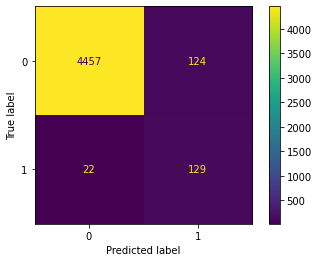

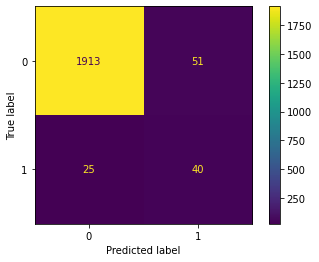

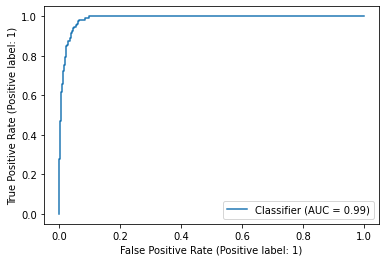

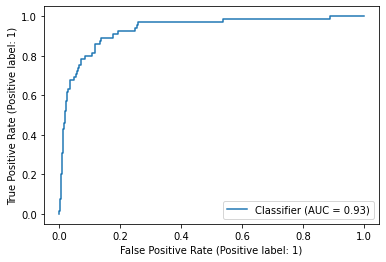

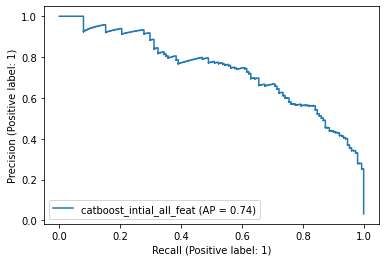

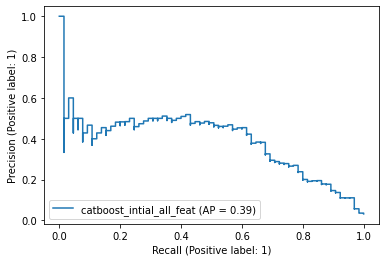

In [124]:
model_performance(y_true_train=y_train,y_true_test=y_test, 
y_pred_train=pred_train_cat,y_pred_test=pred_test_cat,
threshold=0.5,title="catboost_intial_all_feat")

In [125]:
explainer2 = shap.TreeExplainer(mod2)
shap_values2 = explainer2.shap_values(X_train)

In [126]:
top=50
importance_mod2 = get_shap_feat_importance(shap_values2,X_train)
importance_topk = importance_mod2[importance_mod2["shap_importance"]>0][:top]
best_feat = importance_topk.features.values

importance_mod2[importance_mod2["shap_importance"]>0]\
    .to_csv("../data/important_features.csv",index=False)

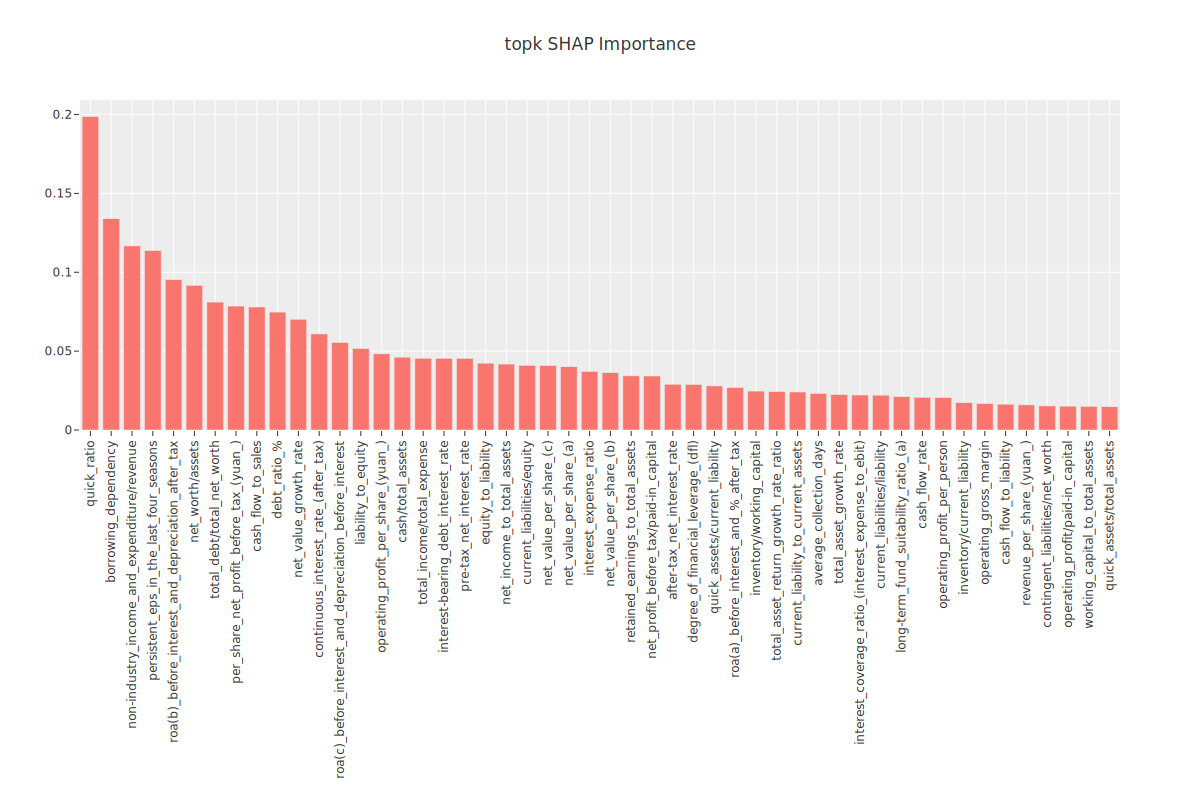

In [127]:
fig = go.Figure([go.Bar(x=importance_topk.features, y=importance_topk.shap_importance)])
fig.update_layout(width=1200, height=800,xaxis_tickangle=-90, title="topk SHAP Importance")
fig.show("svg")


In [128]:
if X_train[best_feat].select_dtypes(exclude=np.number).shape[1]>0:
    print(f"categorical feature detected")
else: 
    print(f"NO categorical feature detected")

NO categorical feature detected


In [129]:

def obj_best_feat(trial):

    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 4, 10),
        #"num_leaves": trial.suggest_int("num_leaves", 4, 20),
        "iterations":trial.suggest_int("iterations", 20,75),
        "l2_leaf_reg":trial.suggest_int("l2_leaf_reg", 2,10),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli","MVS"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered"]),
        "scale_pos_weight":trial.suggest_int("scale_pos_weight", 2,30),
        "random_strength" : trial.suggest_float("random_strength", 0.1, 1),
        #"grow_policy": trial.suggest_categorical("grow_policy",["SymmetricTree"])
        }
    

    # if param["objective"] == "LogLoss":
    #     param["scale_pos_weight"]:trial.suggest_int("scale_pos_weight", 2,30)
    #     #y_train.value_counts()[0]/y_train.value_counts()[1]
        # param["auto_class_weights"]="Balanced"

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = CatBoostClassifier(**param)

    gbm.fit(X_train[best_feat], y_train, eval_set=[(X_test[best_feat], y_test)], verbose=0, 
    early_stopping_rounds=10#,cat_features=["company type"]
    )

    preds = gbm.predict(X_test[best_feat])
    pred_labels = np.rint(preds)
    f_one_score = f1_score(y_test, pred_labels)
    return f_one_score

In [130]:
study2 = optuna.create_study(direction="maximize")
study2.optimize(obj_best_feat, n_trials=50, timeout=600,show_progress_bar=True)

/Users/convergeml/engineering/casestudy/bankruptcy_prediction/.venv/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/50 [00:00<?, ?it/s]

In [131]:
print("Number of finished trials: {}".format(len(study2.trials)))

print("Best trial:")
trial2 = study2.best_trial

print("  Value: {}".format(trial2.value))

best_params2={}
print("  Params: ")
for key, value in trial2.params.items():
    best_params2[key]=value
print(best_params2)

Number of finished trials: 50
Best trial:
  Value: 0.5151515151515151
  Params: 
{'objective': 'Logloss', 'colsample_bylevel': 0.08401802178063367, 'learning_rate': 0.04559382474650909, 'depth': 6, 'iterations': 38, 'l2_leaf_reg': 10, 'bootstrap_type': 'MVS', 'boosting_type': 'Ordered', 'scale_pos_weight': 4, 'random_strength': 0.5398193090464866}


In [132]:
extra_params = {
    #"cat_features":["company type"],
    #scale_pos_weight is supported only for binary classification Logloss loss
    #"scale_pos_weight":y_train.value_counts()[0]/y_train.value_counts()[1] 
    #"auto_class_weights":"Balanced"
    }

best_params2 = {**best_params2, **extra_params}

In [133]:
best_params2

{'objective': 'Logloss',
 'colsample_bylevel': 0.08401802178063367,
 'learning_rate': 0.04559382474650909,
 'depth': 6,
 'iterations': 38,
 'l2_leaf_reg': 10,
 'bootstrap_type': 'MVS',
 'boosting_type': 'Ordered',
 'scale_pos_weight': 4,
 'random_strength': 0.5398193090464866}

In [134]:
# # saving params to csv
# best_params2_df = pd.DataFrame([best_params2])
# best_params2_df.to_csv("../data/best_params.csv",index=False)

In [6]:
# use these when loading a earlier saved model
loaded_best_params = pd.read_csv("../data/best_params.csv",index_col=False).to_dict('records')[0]
best_feat = list(pd.read_csv("../data/important_features.csv")["features"])

In [7]:
final_model_fit=False

if final_model_fit:
    mod3 = CatBoostClassifier(**best_params2)
    mod3.fit(X_train[best_feat],y_train,verbose=0,plot=True)
else:
    mod3 = CatBoostClassifier(**loaded_best_params)
    mod3.load_model("../model/catboost_model")
    
# Get predicted probabilities for each class
pred_train_cat3 = mod3.predict_proba(X_train[best_feat])
pred_test_cat3 = mod3.predict_proba(X_test[best_feat])

Train classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4581
           1       0.52      0.63      0.57       151

    accuracy                           0.97      4732
   macro avg       0.75      0.80      0.78      4732
weighted avg       0.97      0.97      0.97      4732

Test classification report: 
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1964
           1       0.51      0.52      0.52        65

    accuracy                           0.97      2029
   macro avg       0.75      0.75      0.75      2029
weighted avg       0.97      0.97      0.97      2029



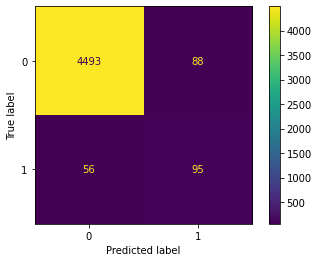

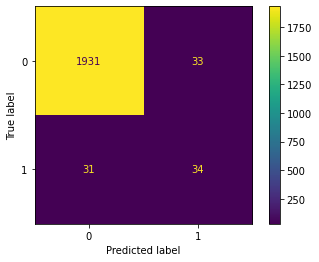

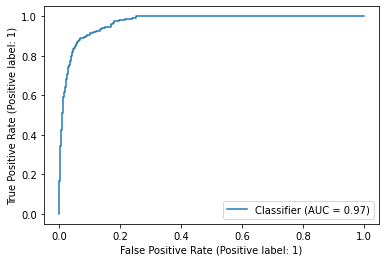

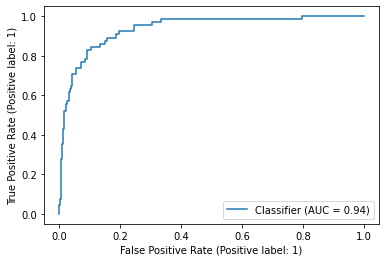

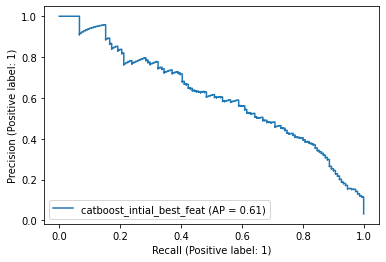

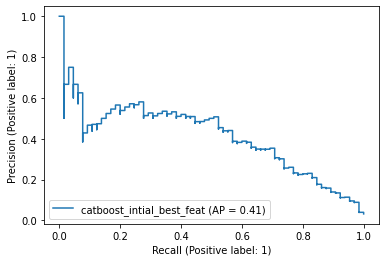

In [8]:
model_performance(y_true_train=y_train,y_true_test=y_test, 
y_pred_train=pred_train_cat3,y_pred_test=pred_test_cat3,
threshold=0.5,title="catboost_intial_best_feat")

Train classification report: 
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4581
           1       0.52      0.63      0.57       151

    accuracy                           0.97      4732
   macro avg       0.75      0.80      0.78      4732
weighted avg       0.97      0.97      0.97      4732

Test classification report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        47
           1       0.33      0.33      0.33         3

    accuracy                           0.92        50
   macro avg       0.65      0.65      0.65        50
weighted avg       0.92      0.92      0.92        50



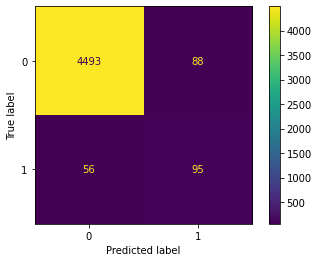

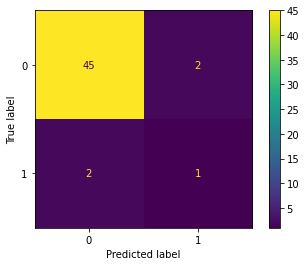

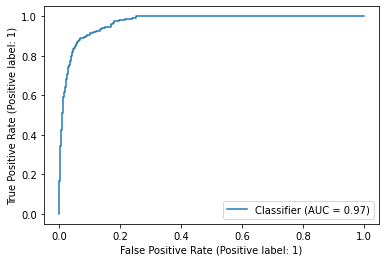

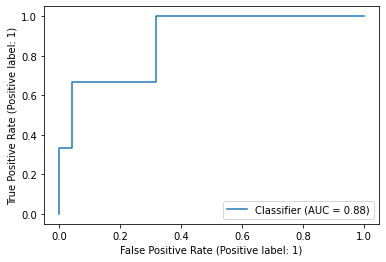

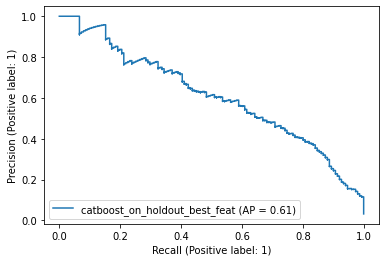

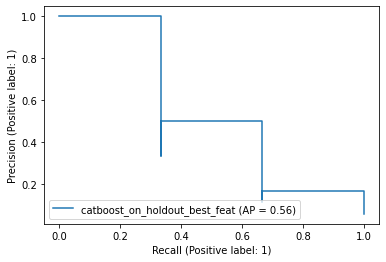

In [9]:
holdout_df = holdout.drop(target,axis = 1)[best_feat]
pred_holdout_cat = mod3.predict_proba(holdout_df)

model_performance(y_true_train=y_train,y_true_test=holdout[target], 
y_pred_train=pred_train_cat3,y_pred_test=pred_holdout_cat,
threshold=0.5,title="catboost_on_holdout_best_feat")

In [10]:
#saving model
#mod3.save_model(fname="../model/catboost_model",format="cbm")

In [11]:
explainer3 = shap.TreeExplainer(mod3)
shap_values3 = explainer3.shap_values(X_train[best_feat])

In [19]:
importance_mod3 = get_shap_feat_importance(shap_values3,X_train[best_feat])
best_feat3 = list(importance_mod3.features.values)

# importance_mod3[importance_mod3["shap_importance"]>0]\
#     .to_csv("../data/final_important_features.csv",index=False)

**Some Definitions Found off the internet (data dictionary contains very brief descriptions)**

* Quick Ratio: The quick ratio is an indicator of a company’s short-term liquidity position and measures a company’s ability to meet its short-term obligations with its most liquid assets.it indicates the company’s ability to instantly use its near-cash assets (assets that can be converted quickly to cash) to pay down its current liabilities
  
* Earnings per share (EPS) is calculated as a company's profit divided by the outstanding shares of its common stock. The resulting number serves as an indicator of a company's profitability.
  
* Borrowing Dependency: The cost of debt is the effective interest rate that a company pays on its debts, such as bonds and loans. The cost of debt can refer to the before-tax cost of debt, which is the company's cost of debt before taking taxes into account, or the after-tax cost of debt.

* Net Worth: Net worth is the value of the assets a person or corporation owns, minus the liabilities they owe.

* Debt Ratio = $\frac{TotalDebt}{TotalAssets}$

* Class A and B shares: The difference between Class A shares and Class B shares of a company’s stock usually comes down to the number of voting rights assigned to the shareholder. Class A shareholders generally have more clout.

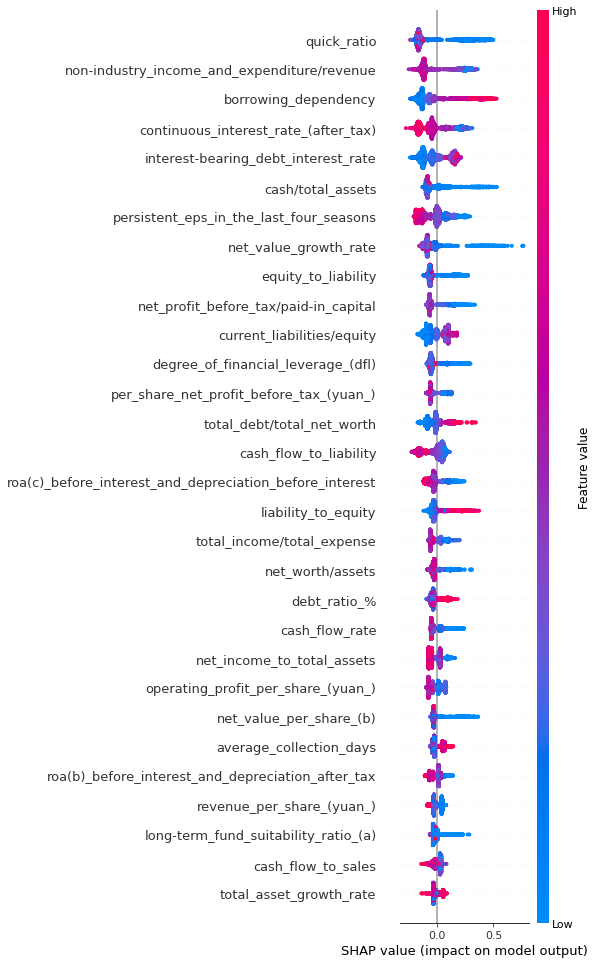

In [13]:
shap.summary_plot(shap_values3,X_train[best_feat],max_display=30)

Feature importance by SHAP values is given above:
fog e.g. **Quick ratio** -> `Lower values` of quick ratio contribute more towards predicting bankruptcy. The following table summarises this contribution for top 30 features.

|features|shap_importance|(high/low) values contribute to bankruptcy| | |
|:----|:----|:----|:----|:----|
|quick_ratio|0.194|low|
|non-industry_income_and_expenditure/revenue|0.149|low|
|borrowing_dependency|0.145|high|
|continuous_interest_rate_(after_tax)|0.110|low|
|interest-bearing_debt_interest_rate|0.106|high|
|cash/total_assets|0.101|low|
|persistent_eps_in_the_last_four_seasons|0.091|low|
|net_value_growth_rate|0.088|low|
|equity_to_liability|0.084|low|
|net_profit_before_tax/paid-in_capital|0.081|low|
|current_liabilities/equity|0.078|high|
|degree_of_financial_leverage_(dfl)|0.069|low|
|per_share_net_profit_before_tax_(yuan_)|0.064|low|
|total_debt/total_net_worth|0.064|high|
|cash_flow_to_liability|0.061|low|
|roa(c)_before_interest_and_depreciation_before_interest|0.059|low|
|liability_to_equity|0.052|high|
|total_income/total_expense|0.051|low|
|net_worth/assets|0.045|low|
|debt_ratio_%|0.044|high|
|cash_flow_rate|0.044|low|
|net_income_to_total_assets|0.044|low|
|operating_profit_per_share_(yuan_)|0.043|low|
|net_value_per_share_(b)|0.040|low|
|average_collection_days|0.037|high|
|roa(b)_before_interest_and_depreciation_after_tax|0.035|low|
|revenue_per_share_(yuan_)|0.031|low|
|long-term_fund_suitability_ratio_(a)|0.028|low|
|cash_flow_to_sales|0.027|low|
|total_asset_growth_rate|0.026|mix|


## Interaction Plots
Interaction plots below uses shap values to indicate how a business is more likely to go bankrupt (yaxis >0) very much like summary plots. However, it gives as an additional view on on feature interaction.
As an example, `plot 14` in the grid show that Businesses that have higher total_debt/total_net_worth contribute less towards bankruptcy and among those business most of them have high quick ratio, meaning they have better short term liquidity position.

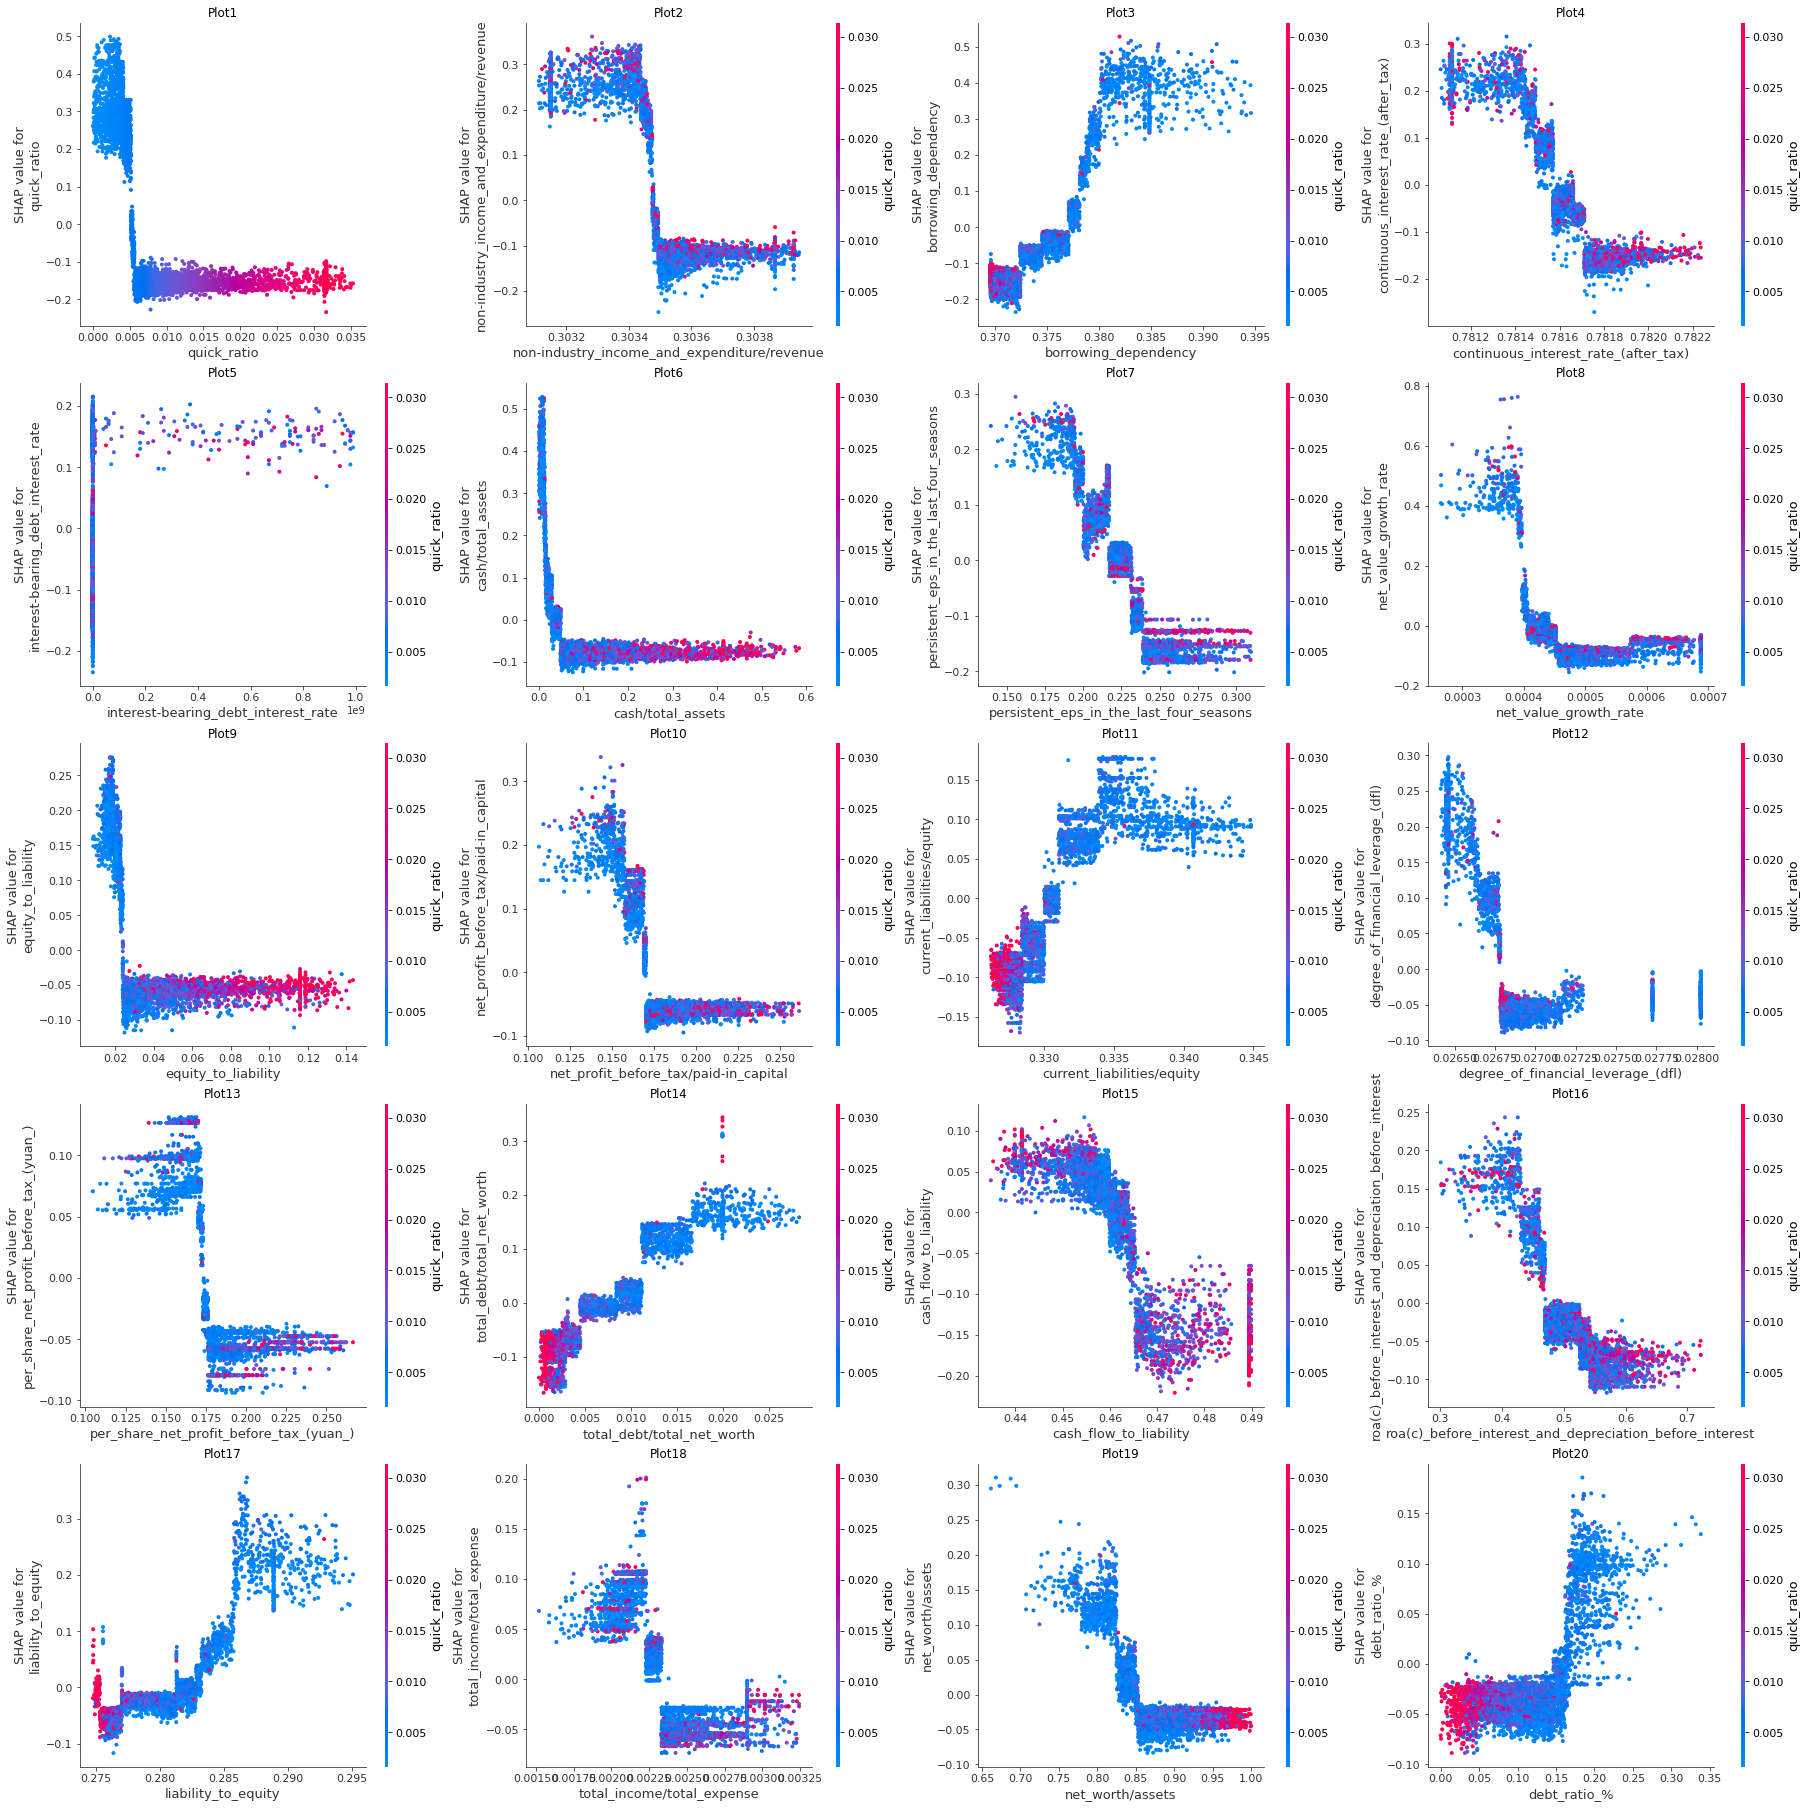

In [21]:
_, axes = plt.subplots(nrows=5,ncols=4,figsize=(25,25),constrained_layout=True)
axes=axes.ravel()
k=-1
for i in range(5):
    for j in range(4):
        k+=1
        var = str(best_feat3[k])
        shap.dependence_plot(var, shap_values3, X_train[best_feat],interaction_index="quick_ratio",ax=axes[k],show=False)
        axes[k].set_title(f"Plot{k+1}")
        if k==20:
            break

Quick ratio is the most important feature for this model, if we look at `plot 3` we observe that while lower value of quick ratio contributes more towards bankruptcy but they also have higher borrowing dependency. A similar behaviour is seen for debt_ratio% in `plot 20`

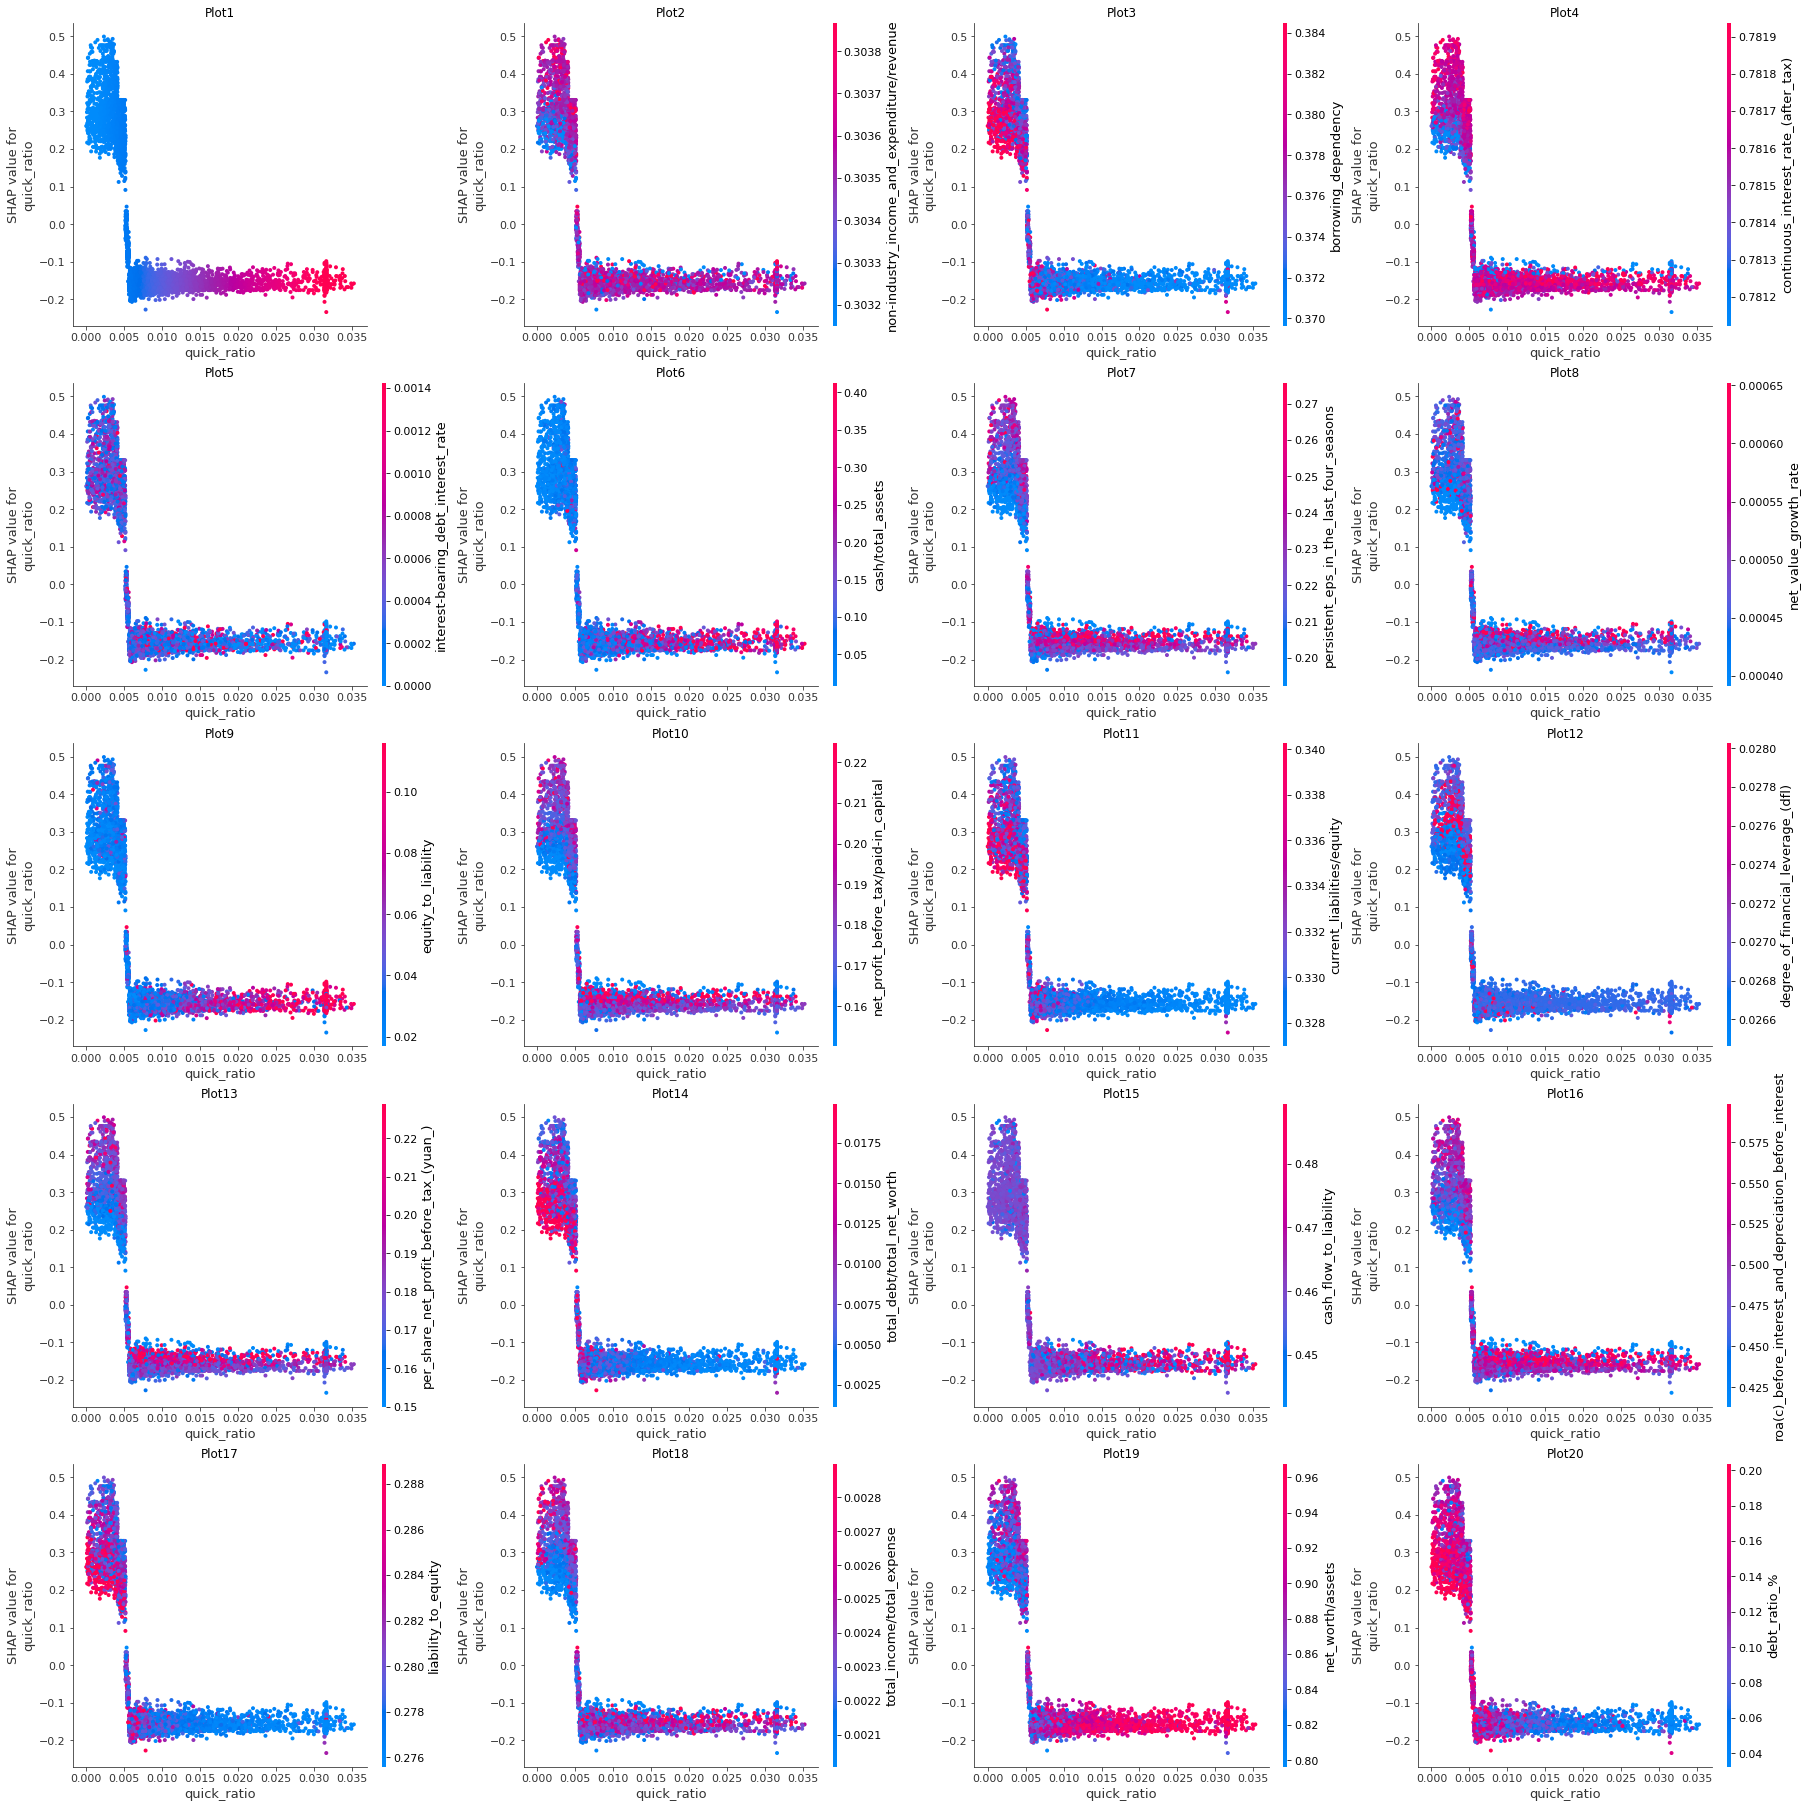

In [22]:
_, axes = plt.subplots(nrows=5,ncols=4,figsize=(25,25),constrained_layout=True)
axes=axes.ravel()
k=-1
for i in range(5):
    for j in range(4):
        k+=1
        var = str(best_feat3[k])
        shap.dependence_plot("quick_ratio", shap_values3, X_train[best_feat],interaction_index=var,ax=axes[k],show=False)
        axes[k].set_title(f"Plot{k+1}")
        if k==21:
            break

For non-industry_income_and_expenditure/revenue lower values contributes towards bankruptcy and its interaction with eps(earning per share) `plot 7` indicates lower values of the features teands to also have lower values of eps. 

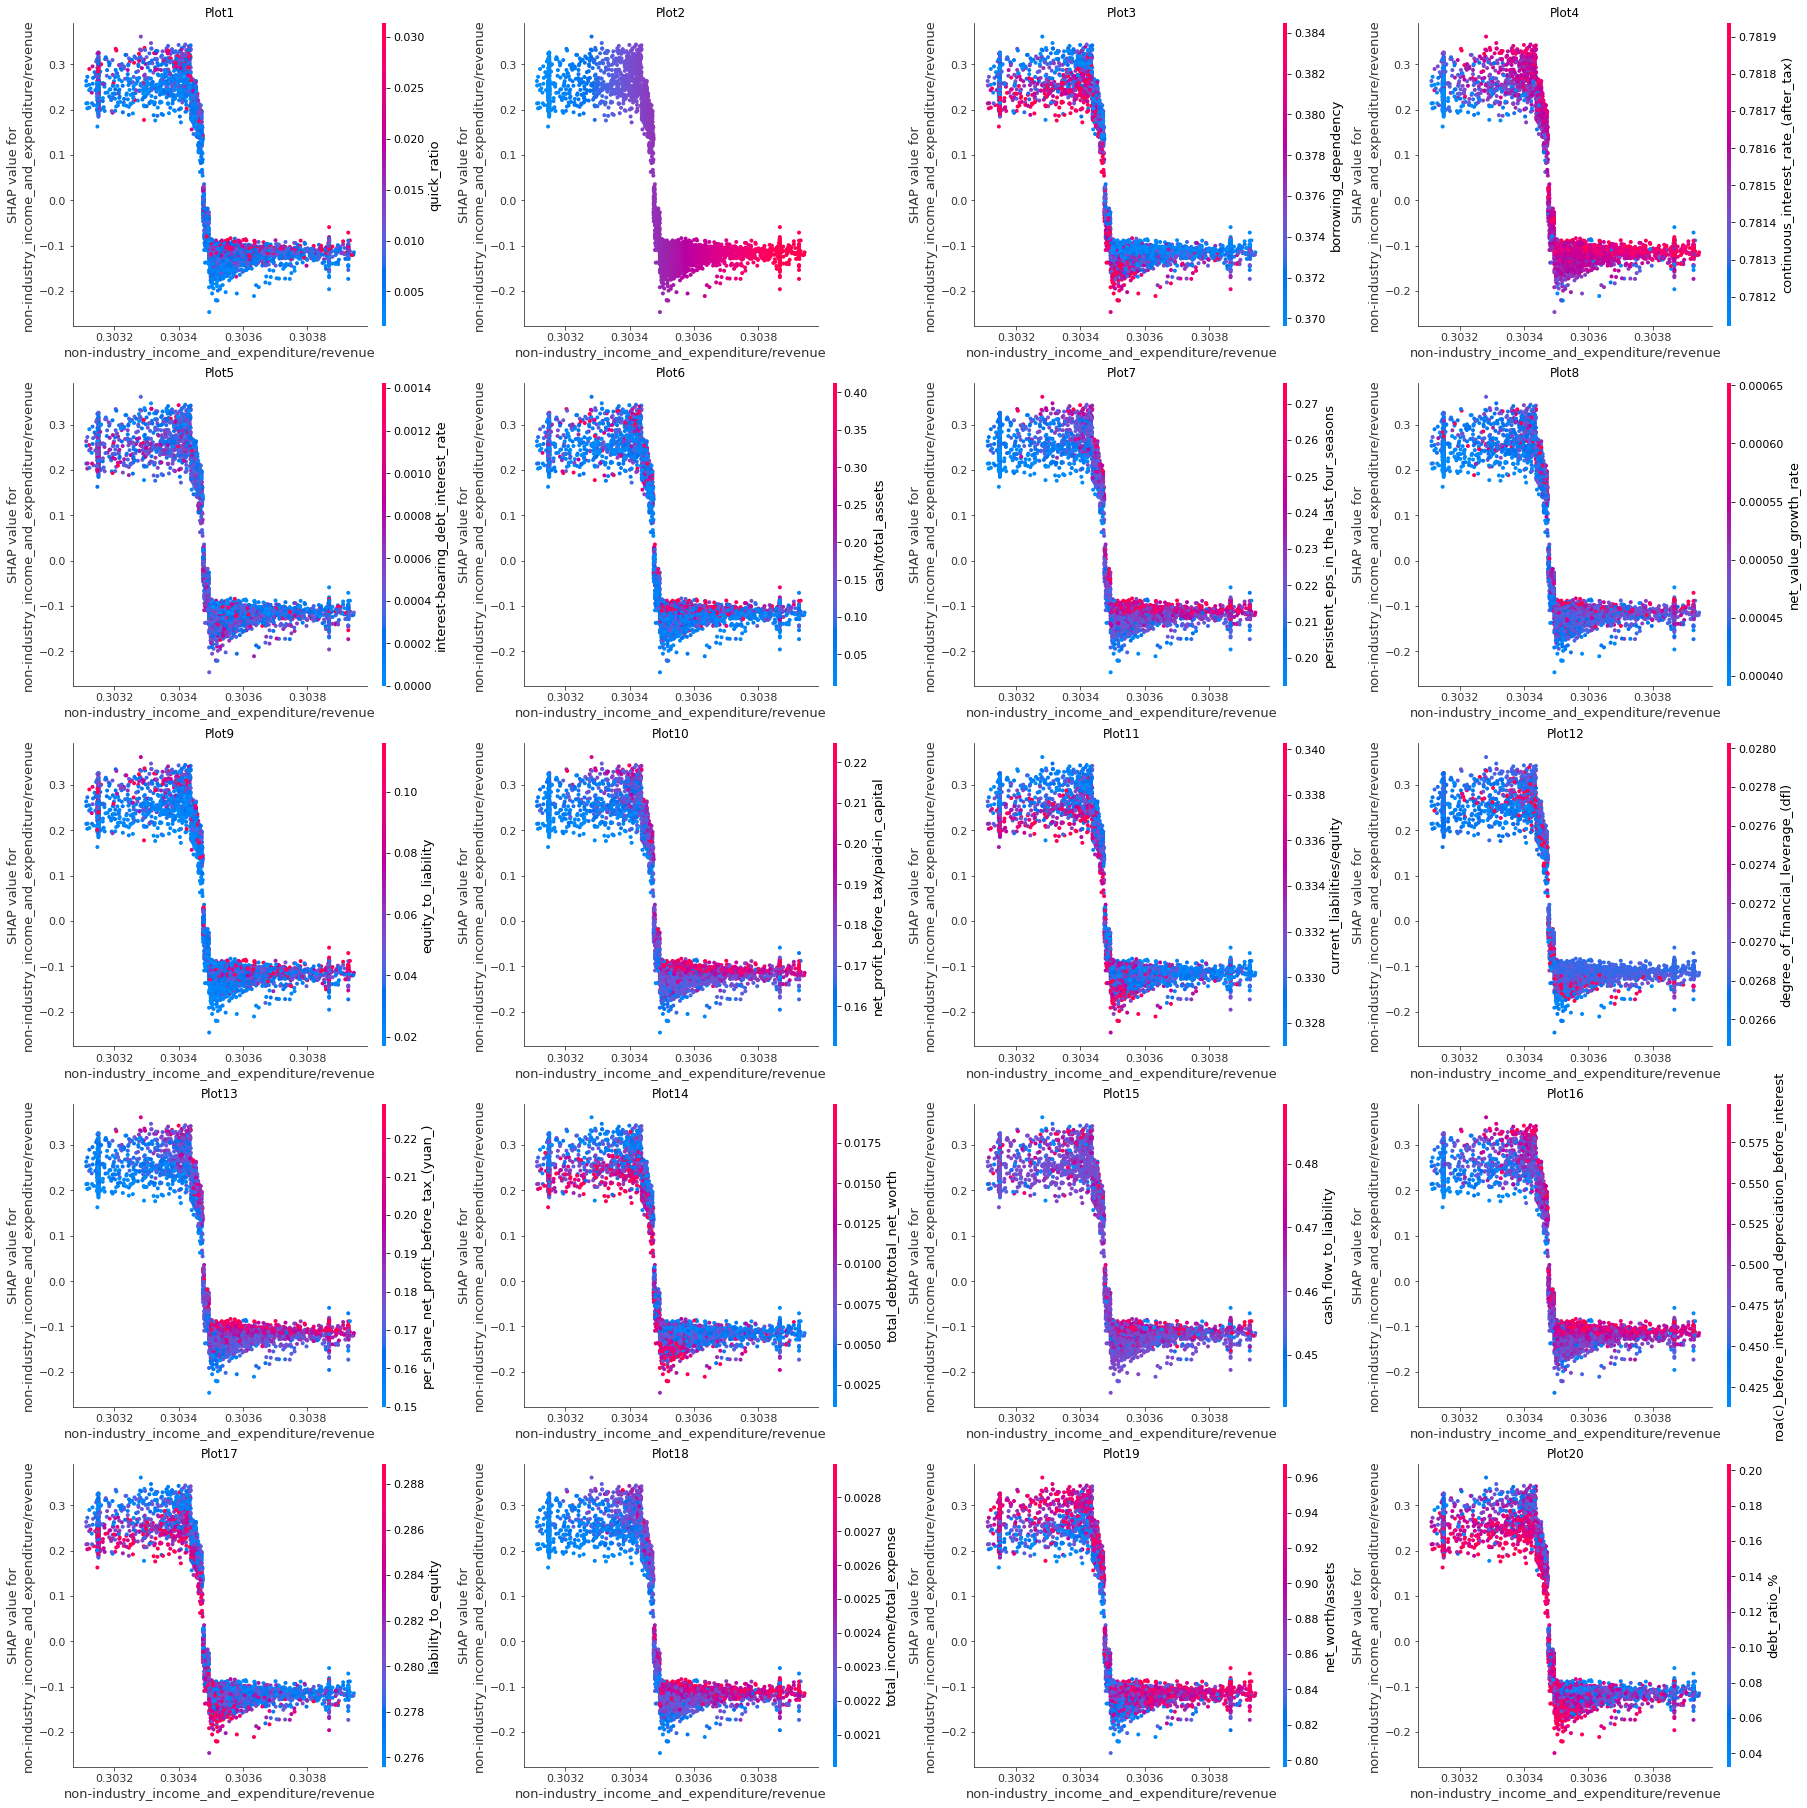

In [23]:
_, axes = plt.subplots(nrows=5,ncols=4,figsize=(25,25),constrained_layout=True)
axes=axes.ravel()
k=-1
for i in range(5):
    for j in range(4):
        k+=1
        var = str(best_feat3[k])
        shap.dependence_plot("non-industry_income_and_expenditure/revenue", shap_values3, X_train[best_feat],interaction_index=var,ax=axes[k],show=False)
        axes[k].set_title(f"Plot{k+1}")
        if k==21:
            break

### Next Steps
* Get more data so we could perform cross validation to build a more robust model.
* PCA could also be used but this would mean loss of interpretability.
* Explore whatif scenarios i.e. [counterfactuals](http://interpret.ml/DiCE/notebooks/DiCE_getting_started.html).
* We could also enforce [monotonicity](https://catboost.ai/en/docs/references/training-parameters/common#monotone_constraints) if business logic suggests.
* Further drill on specific features of interest with the stakeholders.
* While I tried `lightgbm` it's not avaiable in the notebook as lightgbm performed extremely poorly and also its not suitable for small datasets such as this. We could also however experiment with XGboost to see if we could get better performance.
* A Streamit web app would be great to discover more pattern in the data using SHAP.